Code: Intrinsic Image decompositon and Shadow segmentation                      
Members:
-Hrigved Suryawanshi,
Haard Shah,
Mathew Ray

In [ ]:
%cd /content

/content


In [ ]:
! ls

sample_data


In [ ]:
!git clone https://github.com/compphoto/Intrinsic.git

Cloning into 'Intrinsic'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 194 (delta 47), reused 22 (delta 12), pack-reused 113 (from 1)
Receiving objects: 100% (194/194), 37.41 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
%cd Intrinsic

/content/Intrinsic


In [ ]:

!pip install -e .

Obtaining file:///content/Intrinsic
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/MiDaS (to revision master) to /tmp/pip-install-wnohnord/altered-midas_9bb91a3440544becbbafa10d525badc5
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/MiDaS /tmp/pip-install-wnohnord/altered-midas_9bb91a3440544becbbafa10d525badc5
  Resolved https://github.com/CCareaga/MiDaS to commit ca29fc7041dd11a2347d93046e758bb3c7adaac6
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/chrislib (to revision main) to /tmp/pip-install-wnohnord/chrislib_eba9e01500bb4ed5b852edb2bcf31a6f
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/chrislib /tmp/pip-install-wnohnord/chrislib_eba9e01500bb4ed5b852edb2bcf31a6f
  Resolved https://github.com/CCareaga/chrislib to commit cf818e04e16495e0228d0a418733280538a5857b
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt

from chrislib.data_util import load_image
from intrinsic.pipeline import load_models, run_pipeline

# Load the models from the given paths
models = load_models('v2')

# Load an image (numpy float array in [0-1])
image = load_image('/content/img6.jpg')

# Run the model on the image using R_0 resizing
results = run_pipeline(models, image)

# Extract relevant results
albedo = results['hr_alb']
diffuse_shading = results['dif_shd']
residual = results['residual']
blended_img = results.get('blended_img')  # Ensure this exists in results
shadow_mask = results.get('shadow_mask')  # Ensure this exists in results

Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_0.pt" to /root/.cache/torch/hub/checkpoints/stage_0.pt
100%|██████████| 403M/403M [00:09<00:00, 45.5MB/s]
Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_1.pt" to /root/.cache/torch/hub/checkpoints/stage_1.pt
100%|██████████| 81.8M/81.8M [00:01<00:00, 81.2MB/s]
Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_2.pt" to /root/.cache/torch/hub/checkpoints/stage_2.pt
100%|██████████| 403M/403M [00:06<00:00, 62.8MB/s]
Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_3.pt" to /root/.cache/torch/hub/checkpoints/stage_3.pt
100%|██████████| 403M/403M [00:09<00:00, 42.6MB/s]
Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_4.pt" to /root/.cache/torch/hub/checkpoints/stage_4.pt
100%|██████████| 403M/403M [00:06<00:00, 63.7MB/s]
Downloading: "https://github.com/facebookresearch/WSL-Imag

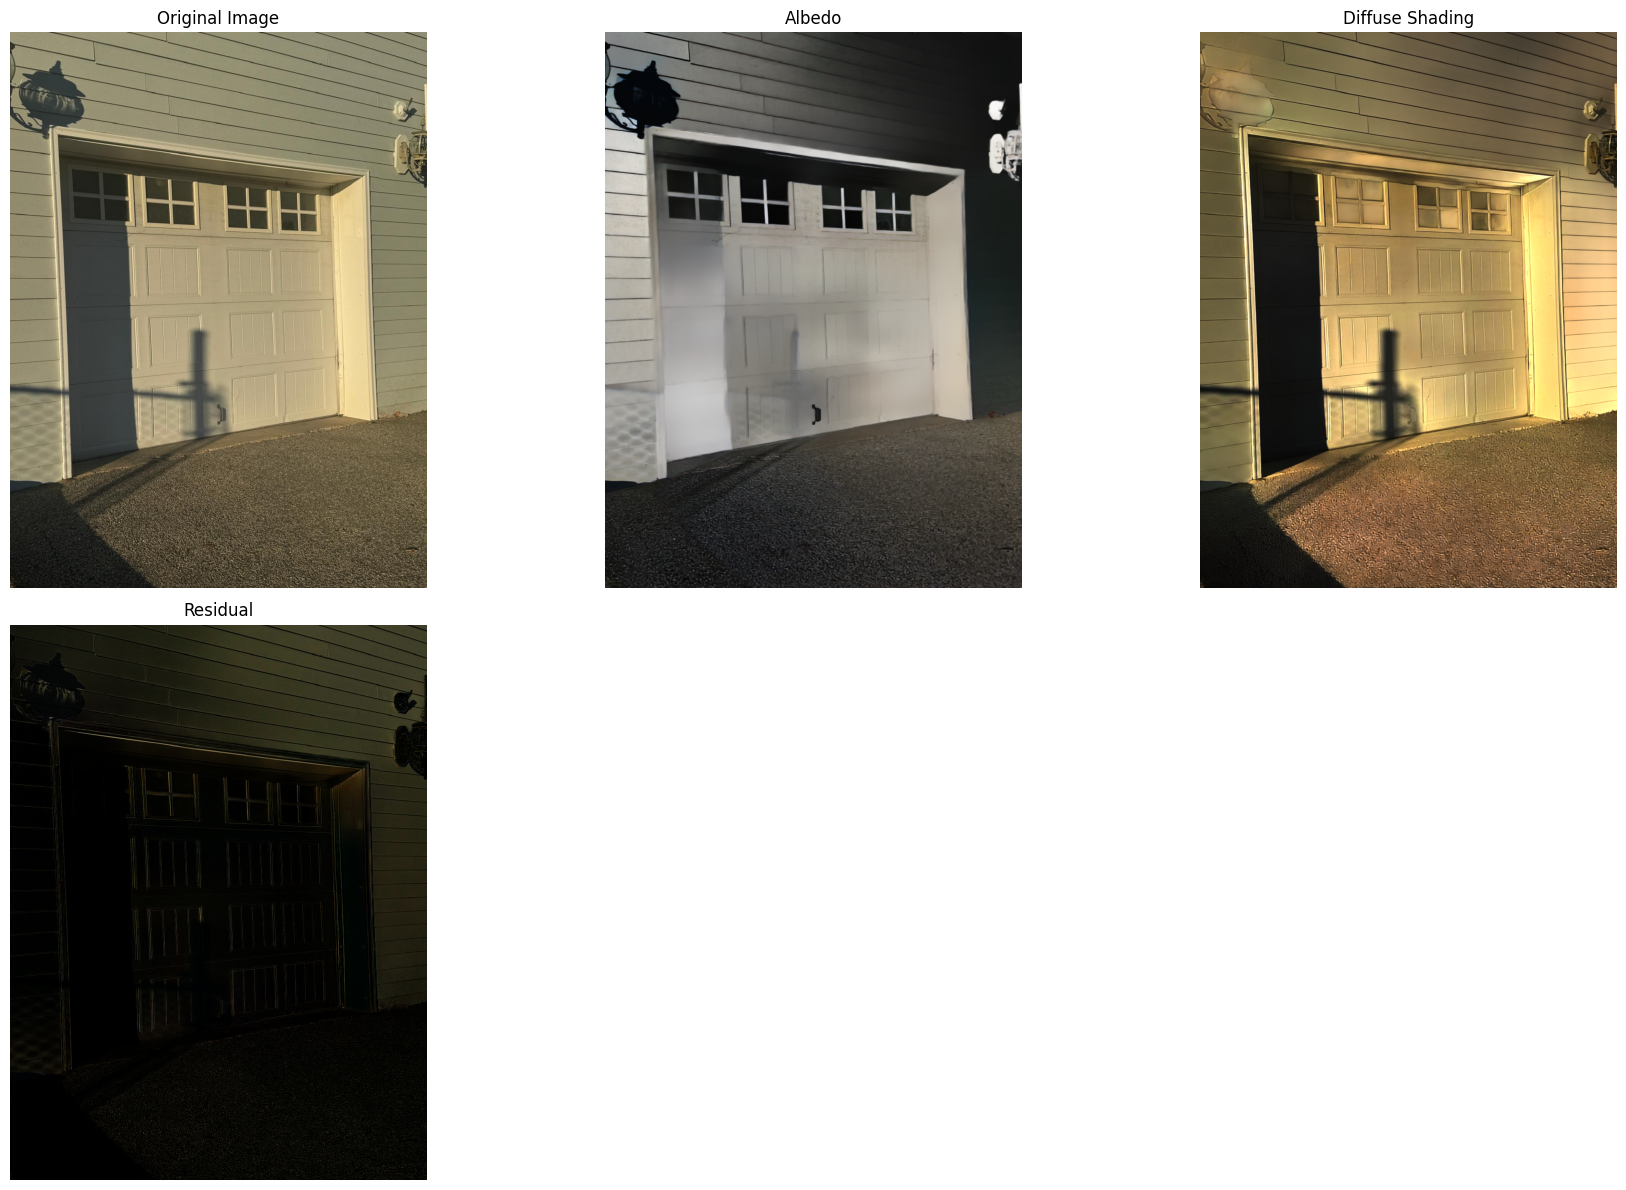

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Albedo
plt.subplot(2, 3, 2)
plt.imshow(albedo)
plt.title('Albedo')
plt.axis('off')

# Diffuse Shading
plt.subplot(2, 3, 3)
plt.imshow(diffuse_shading, cmap='gray')
plt.title('Diffuse Shading')
plt.axis('off')

# Residual
plt.subplot(2, 3, 4)
plt.imshow(residual, cmap='gray')
plt.title('Residual')
plt.axis('off')

# Shadow Mask (if available)
if shadow_mask is not None:
    plt.subplot(2, 3, 5)
    plt.imshow(shadow_mask, cmap='gray')
    plt.title('Shadow Mask')
    plt.axis('off')

# Blended Image (Shadow Removal) (if available)
if blended_img is not None:
    plt.subplot(2, 3, 6)
    plt.imshow(blended_img)
    plt.title('Blended Image (Shadow Removal)')
    plt.axis('off')

plt.tight_layout()
plt.show()

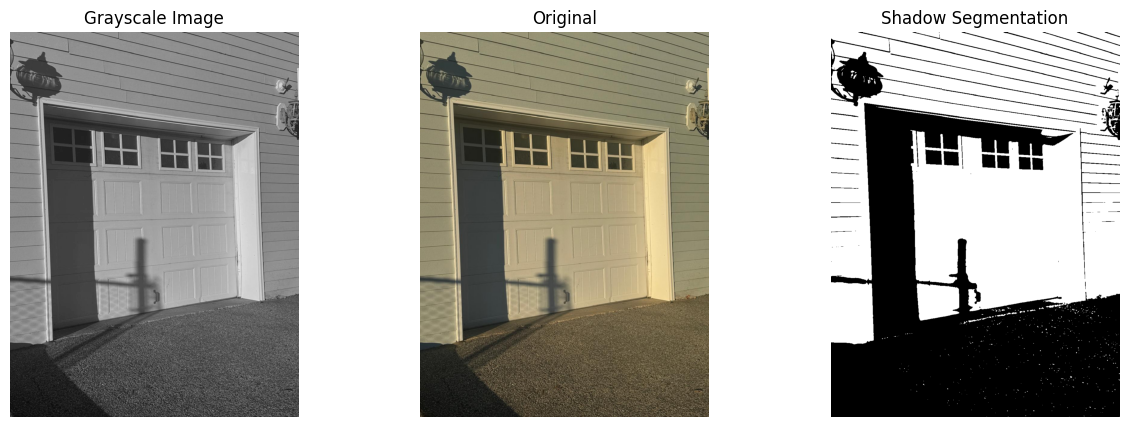

In [ ]:
from sklearn.cluster import KMeans
import cv2
import numpy as np


# Function to display images side by side
def show_images_side_by_side(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.cvtColor(residual, cv2.COLOR_BGR2GRAY)

# Increase kernel size for more blurring (e.g., (15, 15))
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Flatten the blurred image to a 1D array for clustering
pixel_values = blurred.reshape((-1, 1))
pixel_values = np.float32(pixel_values)

# Define criteria and apply KMeans clustering
# KMeans will separate the image into 2 clusters (shadow and non-shadow)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pixel_values)

# Reshape the clustered labels back into the image format
segmented_image = kmeans.labels_.reshape(blurred.shape)

# Since KMeans clusters may assign labels differently, we will assign white to shadows and black to non-shadows
# We assume the darker regions (with lower intensity) are shadows, so we reverse the labels if necessary
if np.mean(blurred[segmented_image == 0]) > np.mean(blurred[segmented_image == 1]):
    segmented_image = np.where(segmented_image == 0, 1, 0)

# Scale the segmented image to 0-255 for visualization
segmented_image = segmented_image * 255

# Plot the original grayscale and the K-Means clustered image side by side
show_images_side_by_side(
    [gray, image, segmented_image],
    ['Grayscale Image', 'Original', 'Shadow Segmentation']
)